In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

p = print

#pls take note of version
#numpy 1.17.3
#pandas 1.0.3
#sklearn 0.21.3

In [2]:
from mlfinlab.util.volatility import get_daily_vol
from mlfinlab.filters import cusum_filter

from mlfinlab.labeling import add_vertical_barrier
from mlfinlab.labeling import get_events
from mlfinlab.labeling import get_bins

dollar = pd.read_csv('./Sample_data/dollar_bars.txt', 
                 sep=',', 
                 header=0, 
                 parse_dates = True, 
                 index_col=['date_time'])




Support us on Patreon: https://www.patreon.com/HudsonThames

MlFinLab needs you! We need your help for us to keep on maintaining and implementing academic research based on 
financial machine learning (for open-source). In order for us to continue we need to raise $4000 of monthly donations
via Patreon - by December 2020. If we can't reach our goal, we will need to adopt more of a paid for service. We thought
that the best and least impactful course of action (should we not reach our goal) is to leave the package as open-source
but to make the documentation (ReadTheDocs) a paid for service. This is the ultimate litmus test, if the package is a 
value add, then we need the community to help us keep it going.

Our road map for 2020 is to implement the text book: Machine Learning for Asset Managers by Marcos Lopez de Prado, 
as well as a few papers from the Journal of Financial Data Science. We are hiring a full time developer for 3 months 
to help us reach our goals. The money that you

In [3]:
dollar['close'].describe()

count    24079.000000
mean      2061.126864
std         88.690949
min       1805.750000
25%       2013.750000
50%       2073.250000
75%       2114.250000
max       2272.000000
Name: close, dtype: float64

In [4]:
vol = get_daily_vol(dollar['close'], lookback = 21)
cusum_events = cusum_filter(dollar['close'], threshold=vol.mean())

p("Total events after cusum filtered: {0}".format(cusum_events.shape[0]))

Total events after cusum filtered: 2611


In [5]:
vertical_barriers = add_vertical_barrier(t_events = cusum_events,
                                         close = dollar['close'],
                                         num_days = 1)

In [6]:
pt_sl = [1, 1]

# min_ret must always be higher than cusum filter threshold
min_ret = 0.005
triple_barrier_events = get_events(close=dollar['close'],
                                   t_events = cusum_events,
                                   pt_sl = pt_sl,
                                   target = vol,
                                   min_ret = min_ret,
                                   num_threads = 3,
                                   vertical_barrier_times = vertical_barriers,
                                   side_prediction = None)

2020-05-06 21:07:21.714795 100.0% apply_pt_sl_on_t1 done after 0.11 minutes. Remaining 0.0 minutes.


In [7]:
meta_label = get_bins(triple_barrier_events, dollar['close'])
meta_label['bin'].value_counts()

# 0 means vertical barrier was hit first rather than take profit or stop loss limit

 1    395
-1    372
 0    108
Name: bin, dtype: int64

## Mean-reversion Strategy

Exercise 3.5

Design a mean-reversion strategy using boillinger band before feeding to random forest.

In [8]:
def bband(data: pd.DataFrame, window: int = 21, width: float = 0.001):
    avg = data['close'].ewm(span = window).mean()
    std = avg * width
    upper = avg + std
    lower = avg - std
    return avg, upper, lower, std

dollar['ewm'], dollar['upper'], dollar['lower'], dollar['std'] = bband(dollar)

# Check for normality, serial correlation, overall statistical properties, frequency count stability

In [9]:
dollar['side'] = np.nan

def side_pick(data: pd.DataFrame):
    for i in np.arange(data.index.shape[0]):
        if (data['close'].iloc[i] >= data['upper'].iloc[i]):
            data['side'].iat[i] = -1
        elif (data['close'].iloc[i] <= data['lower'].iloc[i]):
            data['side'].iat[i] = 1
    return data

upper = dollar[dollar['upper'] < dollar['close']] # short signal
lower = dollar[dollar['lower'] > dollar['close']] # long signal

p("Num of times upper limit touched: {0}\nNum of times lower limit touched: {1}"
  .format(upper.count()[0], 
          lower.count()[0]))

# Recall white test as a benchmark and until this stage we filtered all those which did not meet min return
dollar = side_pick(dollar)
dollar.dropna(inplace= True)
dollar['side'].value_counts()

#slightly imbalanced

Num of times upper limit touched: 8495
Num of times lower limit touched: 7811


-1.0    8495
 1.0    7811
Name: side, dtype: int64

In [10]:
vol = get_daily_vol(dollar['close'], lookback = 14)

cusum_events = cusum_filter(dollar['close'], threshold=vol.mean())

p("Total events after cusum filtered: {0}\nThreshold: {1}".format(cusum_events.shape[0], vol.mean()))

# Up till this stage you can still play "cheat" by getting optimal values by experimental mathematics
# hint: first 4 key factors will very much determine 50% of your strategy

Total events after cusum filtered: 2169
Threshold: 0.004044819271227875


In [11]:
# Quick check on data till this stage

dollar.head(6)

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,ewm,upper,lower,std,side
date_time,,,,,,,,,,,,
2015-01-02 07:07:35.156,2056.75,2067.25,2056.25,2064.00,33968,70010061.25,14514,2060.547619,2062.608167,2058.487071,2.060548,-1.0
2015-01-02 14:19:33.847,2061.00,2064.25,2058.75,2063.75,33958,70000723.25,12332,2061.404789,2063.466193,2059.343384,2.061405,-1.0
2015-01-02 14:33:39.311,2063.75,2064.75,2060.00,2064.50,33944,70001009.00,12846,2062.050864,2064.112915,2059.988814,2.062051,-1.0
2015-01-02 14:42:28.315,2064.50,2066.50,2063.25,2066.00,33901,70010093.25,13032,2062.788295,2064.851084,2060.725507,2.062788,-1.0
2015-01-02 15:01:45.497,2063.50,2064.00,2058.75,2058.75,34008,70122046.75,13873,2062.252963,2064.315216,2060.190710,2.062253,1.0
2015-01-02 15:06:57.293,2058.75,2062.00,2056.75,2058.75,33998,70015029.25,13150,2061.734698,2063.796433,2059.672964,2.061735,1.0


In [12]:
vertical_barriers = add_vertical_barrier(t_events = cusum_events,
                                         close = dollar['close'],
                                         num_days = 1)

# If you notice we have more short signal than long signal
pt_sl = [0, 2]
# min_ret must always be higher than cusum filter threshold
min_ret = 0.005

triple_barrier_events = get_events(close=dollar['close'],
                                   t_events = cusum_events,
                                   pt_sl = pt_sl,
                                   target = vol,
                                   min_ret = min_ret,
                                   num_threads = 3,
                                   vertical_barrier_times = vertical_barriers,
                                   side_prediction = dollar['side'])

2020-05-06 21:07:32.899734 100.0% apply_pt_sl_on_t1 done after 0.12 minutes. Remaining 0.0 minutes.


In [13]:
# num of profitable trades
# this is actually quite balanced, so in this sense we don't have to downsample majority or upsample minority
# https://elitedatascience.com/imbalanced-classes

meta_label = get_bins(triple_barrier_events, dollar['close'])
dollar0 = dollar.reindex(meta_label.index).copy()
meta_label['bin'].value_counts()

0    388
1    332
Name: bin, dtype: int64

In [14]:
#num of short signal vs long signal

meta_label['side'].value_counts()

 1.0    369
-1.0    351
Name: side, dtype: int64

In [15]:
sh_false = meta_label[(meta_label['side'] == -1.0) & (meta_label['bin'] == 0)].count()[0]
ln_false = meta_label[(meta_label['side'] == 1.0) & (meta_label['bin'] == 0)].count()[0]

p("short signal with false positive: {0}\nlong signal with false positive: {1}"
  .format(sh_false, ln_false))

short signal with false positive: 207
long signal with false positive: 181


In [16]:
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller, kpss

def report_matrix(actual: pd.Series, pred: pd.Series):
    if (actual.value_counts()[1] < actual.value_counts()[0]) and pred.iloc[1] != 1:
        p("prediction value should be 1\n")
    elif (actual.value_counts()[1] > actual.value_counts()[0]) and pred.iloc[1] != 0:
        p("prediction value should be 0\n")
    
    sep = "=" * 55
    p(" Classification Report\n{0}\n{1}\n"
      .format(sep, 
              classification_report(y_true=actual,
                                    y_pred=pred)))

    p(" Confusion Matrix\n{0}\n{1}\n{2}\n".format(sep,"[[TN, FP]\n [FN, TP]]\n", confusion_matrix(actual, pred)))

    p(" Accuracy Score\n{0}\n{1}\n".format(sep, accuracy_score(actual, pred)))

C:\Users\Wei_X\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [17]:
# This is a quick trick to see [TP FP]

forecast0 = meta_label['bin'].to_frame(name = 'actual')
forecast0['side'] = meta_label['side'] # you don't need this step its optional
forecast0['pred'] = pd.Series(1, index = forecast0.index) # by default we choose how many labels are profitable
    
report_matrix(forecast0['actual'], forecast0['pred']) # we will be focus on True positive

 Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       388
           1       0.46      1.00      0.63       332

    accuracy                           0.46       720
   macro avg       0.23      0.50      0.32       720
weighted avg       0.21      0.46      0.29       720


 Confusion Matrix
[[TN, FP]
 [FN, TP]]

[[  0 388]
 [  0 332]]

 Accuracy Score
0.46111111111111114



C:\Users\Wei_X\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
# confirm stationary using adf > 0.05 and kpss < 0.05 to pass test

p(adfuller(dollar0['close'], maxlag=1, regression='c', autolag ='AIC')[1])
p(kpss(dollar0['close'], regression='ct', lags='auto')[1])


0.3279245669880023
0.01


C:\Users\Wei_X\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [19]:
dollar0['log_price'] = np.log(dollar0['close']) #this will be our stationary feature
dollar0['log_return'] = dollar0['log_price'].diff()

# Before you use ARIMA pls make sure data input is stationary

from statsmodels.tsa.arima_model import ARMA
def ar_model_resid(data: pd.DataFrame, nlags: int = 3):
    for i in np.arange(nlags):
        ar_model = ARMA(data['close'], order=(i,0)).fit().resid
        data['ar_'+ str(i)] = ar_model
    return data

def ma_model_resid(data: pd.DataFrame, nlags: int = 3):
    for i in np.arange(1, nlags + 1):
        try:
            ma_model = ARMA(data['close'], order=(0,i)).fit().resid
            data['ma_'+ str(i)] = ma_model
        except:
            break
    return data

In [20]:
dollar0 = ar_model_resid(dollar0)
dollar0 = ma_model_resid(dollar0)
dollar0

C:\Users\Wei_X\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Wei_X\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Wei_X\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Wei_X\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so wi

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,ewm,upper,lower,std,side,log_price,log_return,ar_0,ar_1,ar_2,ma_1,ma_2,ma_3
2015-01-06 15:46:15.037,2018.25,2018.75,2013.75,2013.75,34718,70000590.00,11764,2017.468622,2019.486091,2015.451153,2.017469,1.0,7.607754,NaN,48.051389,28.646805,26.969687,47.884639,47.757164,47.597357
2015-01-07 16:55:16.638,2013.00,2017.25,2012.50,2017.25,34745,70000093.00,10407,2009.995268,2012.005263,2007.985273,2.009995,-1.0,7.609490,0.001737,51.551389,3.901155,3.873282,27.725271,18.226405,13.370552
2015-01-08 01:48:57.964,2021.50,2038.25,2021.00,2037.25,34490,70003975.75,16212,2019.258574,2021.277833,2017.239315,2.019259,-1.0,7.619356,0.009866,71.551389,20.450167,20.556969,53.261507,42.098980,34.784545
2015-01-09 11:47:24.038,2053.75,2053.75,2048.50,2048.75,34123,70005844.50,15007,2052.776761,2054.829538,2050.723984,2.052777,1.0,7.624985,0.005629,83.051389,12.230236,13.046552,44.014732,23.948270,16.742264
2015-01-09 13:41:02.611,2056.00,2062.00,2056.00,2058.00,33991,70006050.75,11403,2053.483410,2055.536894,2051.429927,2.053483,-1.0,7.629490,0.004505,92.301389,10.141276,10.575280,58.123453,38.332545,25.671836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-11-10 05:25:08.903,2156.75,2170.50,2156.25,2170.00,32395,70013279.75,7076,2160.014218,2162.174233,2157.854204,2.160014,-1.0,7.682482,0.016963,204.301389,38.578071,38.902818,120.278936,84.747075,73.975272
2016-11-10 15:03:03.811,2170.25,2172.50,2168.00,2168.75,32250,70004504.75,3713,2171.024805,2173.195829,2168.853780,2.171025,1.0,7.681906,-0.000576,203.051389,1.339197,2.778124,99.824747,47.554419,21.277771
2016-11-10 15:26:17.610,2163.00,2163.75,2159.75,2159.75,32391,70029178.00,4403,2166.682065,2168.848747,2164.515383,2.166682,1.0,7.677748,-0.004158,194.051389,-6.428307,-6.646965,108.350729,73.599900,47.561424
2016-11-10 15:37:05.621,2156.75,2157.75,2150.75,2150.75,32496,70009781.50,4105,2162.445001,2164.607446,2160.282556,2.162445,1.0,7.673572,-0.004176,185.051389,-6.554338,-7.106556,92.045321,55.412025,53.098816


In [21]:
# Now to train test, make sure NaN and shape is correct

X = dollar0.copy().dropna()
y = meta_label['bin'].iloc[1:]
X.drop(['open', 'high','low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks'], axis=1, inplace=True)

In [22]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, shuffle=False)

In [23]:
parameters = {'max_depth':[2, 3, 4, 5, 7], #need to skip 6 if not ROC v weird
              'n_estimators':[1, 10, 25, 50, 100, 150, 250, 500],
              'random_state':[42]}

def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')
    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

# best parameter to be used

n_estimators, max_depth = perform_grid_search(X_train, y_train)
c_random_state = 42

[0.50693011 0.45893483 0.47410772 0.48323735 0.48616922 0.49106005
 0.48788966 0.49361365 0.49961747 0.48749985 0.48969366 0.49269413
 0.49863408 0.50416051 0.4986768  0.49907375 0.47207829 0.49673602
 0.49981212 0.50832672 0.51754598 0.51360026 0.51010391 0.50968929
 0.49858693 0.50351413 0.49694643 0.50012298 0.5067196  0.50858661
 0.50678215 0.51028617 0.51660353 0.50769153 0.50762741 0.50269131
 0.5120443  0.51299704 0.5103134  0.5103532 ]


C:\Users\Wei_X\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [24]:
# Random Forest Model

rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators,
                            criterion='entropy', random_state=c_random_state)

# max depth is only 2..
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

              precision    recall  f1-score   support

           0       0.64      0.92      0.76       306
           1       0.82      0.41      0.55       269

    accuracy                           0.68       575
   macro avg       0.73      0.67      0.65       575
weighted avg       0.72      0.68      0.66       575

Confusion Matrix
[[282  24]
 [159 110]]

Accuracy
0.6817391304347826


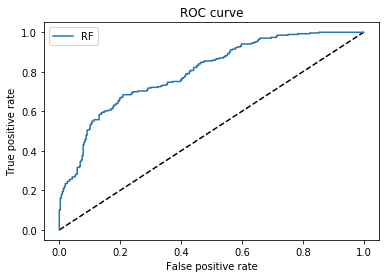

In [25]:

# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

              precision    recall  f1-score   support

           0       0.57      0.80      0.66        81
           1       0.45      0.21      0.28        63

    accuracy                           0.54       144
   macro avg       0.51      0.50      0.47       144
weighted avg       0.51      0.54      0.50       144

Confusion Matrix
[[65 16]
 [50 13]]

Accuracy
0.5416666666666666


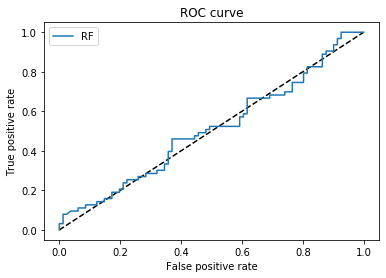

In [26]:
# Meta-label
# Performance Metrics
y_pred_rf = rf.predict_proba(X_validate)[:, 1]
y_pred = rf.predict(X_validate)
fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

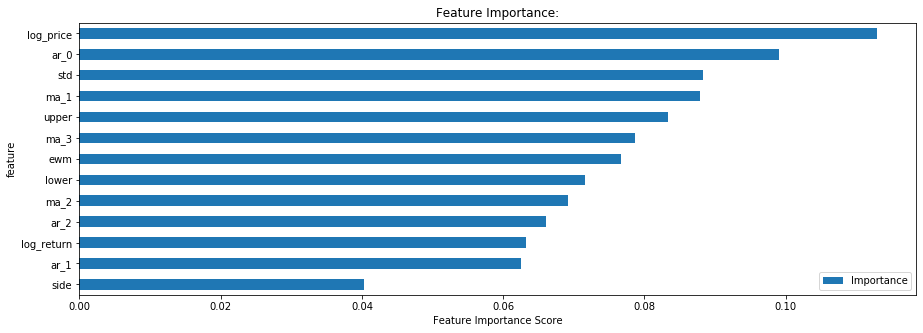

In [27]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()